<a href="https://colab.research.google.com/github/maarsottile/ProyectoDSIIParteI-Sottile-v1/blob/main/ProyectoDSIIParteI-Sottile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Impacto del Contexto Macroeconómico en el Mercado de Autos Usados


## Abstract

*Contexto*

El mercado de autos usados está determinado por características propias del vehículo y por condiciones del entorno económico.
Dado que los automóviles son bienes durables, su comercialización puede verse influenciada por variaciones macroeconómicas.

*Audiencia*

Este análisis está dirigido a equipos comerciales, analistas de negocio y perfiles ejecutivos que buscan comprender mejor la dinámica del mercado.

*Motivación*

El dataset original permite analizar variables internas del vehículo, pero no contempla el contexto económico.
Incorporar datos macroeconómicos permitirá enriquecer el análisis y evaluar posibles asociaciones externas.

*Objetivo*

Obtener datos macroeconómicos mediante la World Bank API, integrarlos al dataset de autos usados y analizar su relación con:
- Precio de venta
- Nivel de demanda (visualizaciones)

*Limitaciones*

- Los indicadores macroeconómicos se analizan a nivel anual.
- No se busca establecer causalidad, sino asociación.
- El dataset no incluye variables socioeconómicas individuales.

## Hipótesis

H1: A mayor inflación, mayor precio promedio de autos usados.  
H2: Un mayor PIB per cápita está asociado con precios promedio más altos.  
H3: Un mayor nivel de desempleo se relaciona con menor demanda.  
H4: Las variables macroeconómicas explican parte de la variabilidad del precio más allá de las características propias del vehículo.

## CARGA Y VALIDACIÓN DEL DATASET ORIGINAL

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

plt.style.use("seaborn-v0_8")


# Paleta
verde_principal = "#2E8B57"
verde_suave = "#6DBE9E"

# Estilo base
sns.set_style("whitegrid")  # activa grilla

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Verde como color por defecto
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[verde_principal])

# Grilla más suave y solo horizontal
plt.rcParams['grid.color'] = '#D9D9D9'
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['grid.linewidth'] = 0.7

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/maarsottile/ProyectoDSParteI-Sottile-v2/refs/heads/main/Used_Car_Price_Prediction.csv")
df.head()

,car_name,yr_mfr,fuel_type,kms_run,sale_price,city,times_viewed,body_type,transmission,variant,...,total_owners,broker_quote,original_price,car_rating,ad_created_on,fitness_certificate,emi_starts_from,booking_down_pymnt,reserved,warranty_avail
0,maruti swift,2015,petrol,8063,386399,noida,18715,hatchback,manual,lxi opt,...,2,397677,404177.0,great,2021-04-04T07:09:18.583,True,8975,57960,False,False
1,maruti alto 800,2016,petrol,23104,265499,noida,2676,hatchback,manual,lxi,...,1,272935,354313.0,great,2021-03-22T14:07:32.833,True,6167,39825,False,False
2,hyundai grand i10,2017,petrol,23402,477699,noida,609,hatchback,manual,sports 1.2 vtvt,...,1,469605,NaN,great,2021-03-20T05:36:31.311,True,11096,71655,False,False
3,maruti swift,2013,diesel,39124,307999,noida,6511,hatchback,manual,vdi,...,1,294262,374326.0,great,2021-01-21T12:59:19.299,True,7154,46200,False,False
4,hyundai grand i10,2015,petrol,22116,361499,noida,3225,hatchback,manual,magna 1.2 vtvt,...,1,360716,367216.0,great,2021-04-01T13:33:40.733,True,8397,54225,False,False


In [3]:
df.shape
df.info()
df.isnull().sum().sort_values(ascending=False)
df.duplicated().sum()
df['sale_price'].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7400 entries, 0 to 7399
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   car_name             7400 non-null   object 
 1   yr_mfr               7400 non-null   int64  
 2   fuel_type            7400 non-null   object 
 3   kms_run              7400 non-null   int64  
 4   sale_price           7400 non-null   int64  
 5   city                 7400 non-null   object 
 6   times_viewed         7400 non-null   int64  
 7   body_type            7297 non-null   object 
 8   transmission         6844 non-null   object 
 9   variant              7400 non-null   object 
 10  assured_buy          7400 non-null   bool   
 11  registered_city      7390 non-null   object 
 12  registered_state     7390 non-null   object 
 13  is_hot               7400 non-null   bool   
 14  rto                  7400 non-null   object 
 15  source               7274 non-null   o

,sale_price
count,7.400000e+03
mean,4.548892e+05
std,2.827023e+05
min,0.000000e+00
25%,2.811740e+05
50%,3.824490e+05
75%,5.401490e+05
max,3.866000e+06


Se realizó una validación estructural del dataset:

- Se verificaron dimensiones y tipos de datos.
- Se analizaron valores faltantes.
- Se evaluaron duplicados.
- Se revisó la distribución del precio.

Se detectaron valores extremos en `sale_price` y `kms_run`.
Dado el carácter comercial del dataset, estos representan segmentos reales del mercado, por lo que se decidió mantenerlos.

In [4]:
#Se prepara variable temporal
# Se transforma la fecha de publicación en formato datetime y se crea una variable anual.
# Esto permitirá integrar los indicadores macroeconómicos, que se reportan por año.

df['ad_created_on'] = pd.to_datetime(df['ad_created_on'], errors='coerce')
df['year_ad'] = df['ad_created_on'].dt.year

## SELECCIÓN Y COMPRENSIÓN DE LA API

Se utiliza la World Bank API por ser una fuente oficial, estructurada y pública.

Estructura de consulta:
https://api.worldbank.org/v2/country/{PAIS}/indicator/{INDICADOR}?format=json

Indicadores seleccionados:
- Inflación (FP.CPI.TOTL.ZG)
- PIB per cápita (NY.GDP.PCAP.CD)
- Desempleo (SL.UEM.TOTL.ZS)

In [6]:
#Función para automatizar la descarga de indicadores.

def get_worldbank_data(indicator):
    url = f"https://api.worldbank.org/v2/country/IND/indicator/{indicator}?format=json&per_page=1000"
    response = requests.get(url)
    data = response.json()
    df_wb = pd.DataFrame(data[1])
    return df_wb

In [7]:
#Descarga de Indicadores

inflation = get_worldbank_data("FP.CPI.TOTL.ZG")[['date','value']]
inflation.columns = ['year','inflation']

gdp = get_worldbank_data("NY.GDP.PCAP.CD")[['date','value']]
gdp.columns = ['year','gdp_per_capita']

unemployment = get_worldbank_data("SL.UEM.TOTL.ZS")[['date','value']]
unemployment.columns = ['year','unemployment']

In [9]:
#Limpieza
#Se convierten los años a formato numérico y se eliminan valores nulos.

#World Bank suele tener datos muy antiguos o años recientes sin valor, por esto se decide eliminar calores nulos

for df_macro in [inflation, gdp, unemployment]:
    df_macro['year'] = pd.to_numeric(df_macro['year'], errors='coerce').astype('Int64')
    df_macro.dropna(inplace=True)

In [10]:
#Consolidación
#Se consolidan los indicadores en un único dataset macroeconómico.
#Se guarda el archivo localmente para asegurar reproducibilidad.

macro = inflation.merge(gdp, on='year', how='inner')
macro = macro.merge(unemployment, on='year', how='inner')

macro.to_csv("macro_data_worldbank.csv", index=False)
macro.head()

,year,inflation,gdp_per_capita,unemployment
0,2024,4.953036,2694.737809,4.173
1,2023,5.649143,2530.120313,4.172
2,2022,6.699034,2347.448294,4.822
3,2021,5.131407,2239.613844,6.380
4,2020,6.623437,1907.042516,7.859


In [11]:
#Integración con DataSet de Autos Usados
#Se integran los indicadores macroeconómicos al dataset principal mediante un join por año.
#Se utiliza un left join para conservar todas las publicaciones de autos.

df = df.merge(macro, left_on='year_ad', right_on='year', how='left')
df.head()

,car_name,yr_mfr,fuel_type,kms_run,sale_price,city,times_viewed,body_type,transmission,variant,...,fitness_certificate,emi_starts_from,booking_down_pymnt,reserved,warranty_avail,year_ad,year,inflation,gdp_per_capita,unemployment
0,maruti swift,2015,petrol,8063,386399,noida,18715,hatchback,manual,lxi opt,...,True,8975,57960,False,False,2021.0,2021,5.131407,2239.613844,6.38
1,maruti alto 800,2016,petrol,23104,265499,noida,2676,hatchback,manual,lxi,...,True,6167,39825,False,False,2021.0,2021,5.131407,2239.613844,6.38
2,hyundai grand i10,2017,petrol,23402,477699,noida,609,hatchback,manual,sports 1.2 vtvt,...,True,11096,71655,False,False,2021.0,2021,5.131407,2239.613844,6.38
3,maruti swift,2013,diesel,39124,307999,noida,6511,hatchback,manual,vdi,...,True,7154,46200,False,False,2021.0,2021,5.131407,2239.613844,6.38
4,hyundai grand i10,2015,petrol,22116,361499,noida,3225,hatchback,manual,magna 1.2 vtvt,...,True,8397,54225,False,False,2021.0,2021,5.131407,2239.613844,6.38


# EDA

**¿Qué determina el precio dentro del mercado?**

1) ¿El año de fabricación influye en el precio?


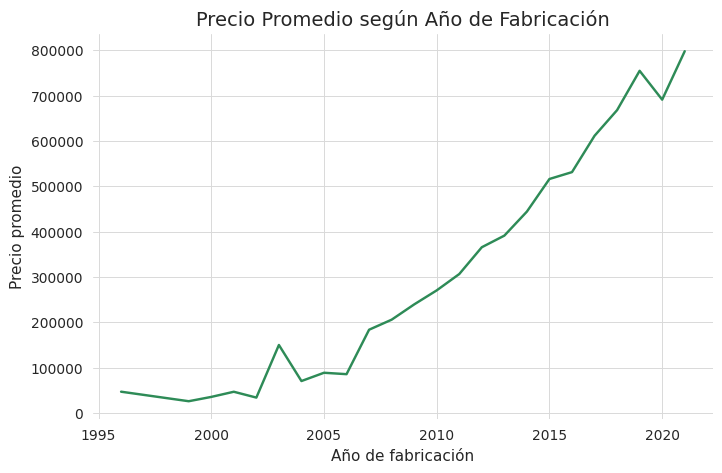

In [63]:
price_by_year = df.groupby('yr_mfr')['sale_price'].mean()

plt.figure(figsize=(8,5))
plt.plot(price_by_year.index, price_by_year.values)
plt.title("Precio Promedio según Año de Fabricación")
plt.xlabel("Año de fabricación")
plt.ylabel("Precio promedio")
plt.show()

Se observa una relación clara entre antigüedad y precio.
Los vehículos más nuevos presentan precios promedio significativamente más altos.

Esto confirma que la depreciación es uno de los principales determinantes del valor en el mercado de autos usados.

¿El kilometraje afecta el precio?

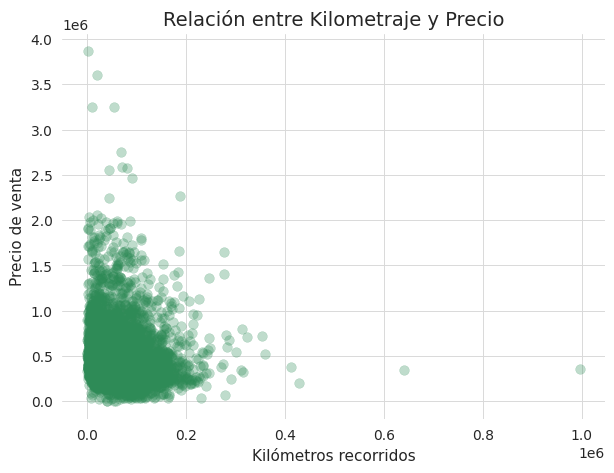

In [64]:
plt.figure(figsize=(7,5))
plt.scatter(df['kms_run'], df['sale_price'], alpha=0.3)
plt.xlabel("Kilómetros recorridos")
plt.ylabel("Precio de venta")
plt.title("Relación entre Kilometraje y Precio")
plt.show()

Se observa una tendencia negativa: a mayor kilometraje, menor precio.
Esto es consistente con el comportamiento esperado del mercado.

¿El tipo de combustible segmenta el mercado?

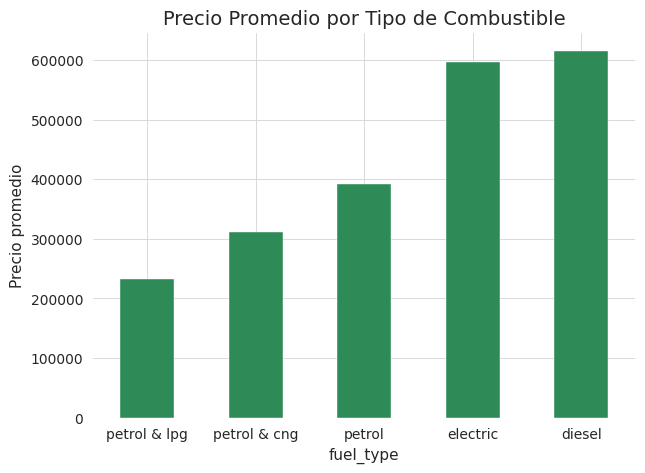

In [66]:
fuel_analysis = df.groupby('fuel_type')['sale_price'].mean().sort_values()

plt.figure(figsize=(7,5))
fuel_analysis.plot(kind='bar')
plt.title("Precio Promedio por Tipo de Combustible")
plt.ylabel("Precio promedio")

plt.xticks(rotation=0)

plt.show()

Existen diferencias claras entre segmentos de combustible.
Esto sugiere que el mercado no es homogéneo y presenta distintos nichos de precio.

**Influencia del contexto macroeconómico**

In [15]:
# Se agregan las variables por año para mantener coherencia con los indicadores macroeconómicos, que se reportan de manera anual.

analysis_df = df.groupby('year_ad')[[
    'sale_price',
    'times_viewed',
    'inflation',
    'gdp_per_capita',
    'unemployment'
]].mean()

In [57]:

sns.set_style("white")
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 11


*H1 — A mayor inflación, mayor precio promedio de autos usados.*

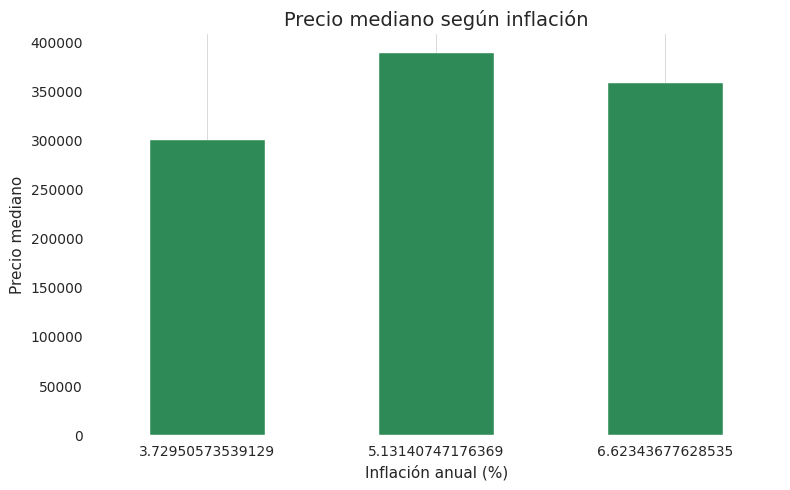

In [68]:
median_price = df.groupby('inflation')['sale_price'].median()

plt.figure()
median_price.plot(kind='bar')

plt.title("Precio mediano según inflación")
plt.xlabel("Inflación anual (%)")
plt.ylabel("Precio mediano")

plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [51]:
df[['sale_price', 'inflation']].corr()

,sale_price,inflation
sale_price,1.000000,-0.005012
inflation,-0.005012,1.000000



El análisis muestra que la correlación entre inflación y precio de venta es prácticamente nula (r ≈ -0.005), lo que indica que no existe una relación lineal significativa entre ambas variables dentro del período analizado.

Esta elevada variabilidad interna dentro de cada año es considerablemente mayor que la variación entre los distintos niveles de inflación. En consecuencia, el contexto inflacionario no parece actuar como un determinante directo del precio de publicación en este dataset.

En términos estratégicos, esto sugiere que la fijación de precios está mayormente influenciada por características estructurales del vehículo (año, kilometraje, modelo, versión) más que por el entorno macroeconómico.

*H2 — Mayor PIB per cápita → precios promedio más altos*

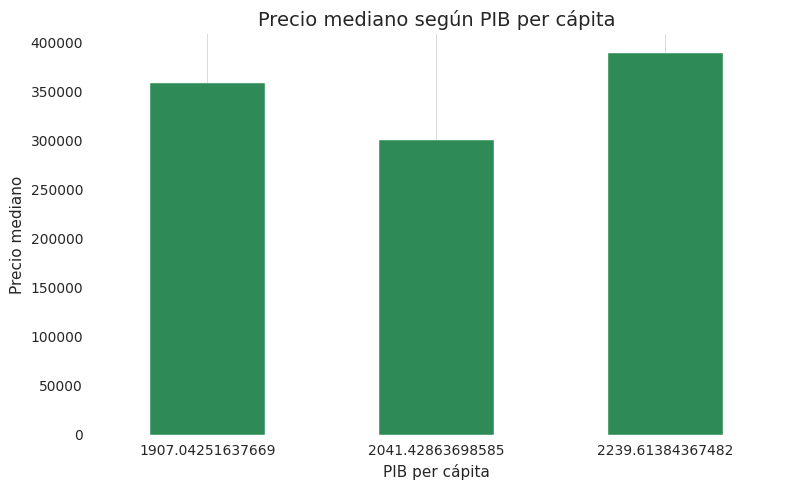

In [71]:
median_price_gdp = df.groupby('gdp_per_capita')['sale_price'].median().sort_index()

plt.figure()

median_price_gdp.plot(kind='bar')

plt.title("Precio mediano según PIB per cápita")
plt.xlabel("PIB per cápita")
plt.ylabel("Precio mediano")

plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()

plt.savefig("H2_pib_precio.png")
plt.show()

In [73]:
df[['sale_price', 'gdp_per_capita']].corr()

,sale_price,gdp_per_capita
sale_price,1.000000,0.067152
gdp_per_capita,0.067152,1.000000


El análisis muestra una correlación positiva pero extremadamente débil entre el PIB per cápita y el precio de venta (r = 0,06).

Las distribuciones de precios según nivel de PIB presentan alta superposición y medianas similares, lo que indica que el crecimiento económico general no se traduce directamente en aumentos en los precios publicados dentro del mercado analizado.

Esto sugiere que, al igual que en el caso de la inflación, las variables macroeconómicas agregadas tienen una influencia limitada sobre la fijación individual de precios en el mercado de autos usados.

En términos estratégicos, el comportamiento del precio parece responder principalmente a factores estructurales del producto más que al contexto macroeconómico general.

*H3 — Desempleo vs Demanda (visualizaciones)*



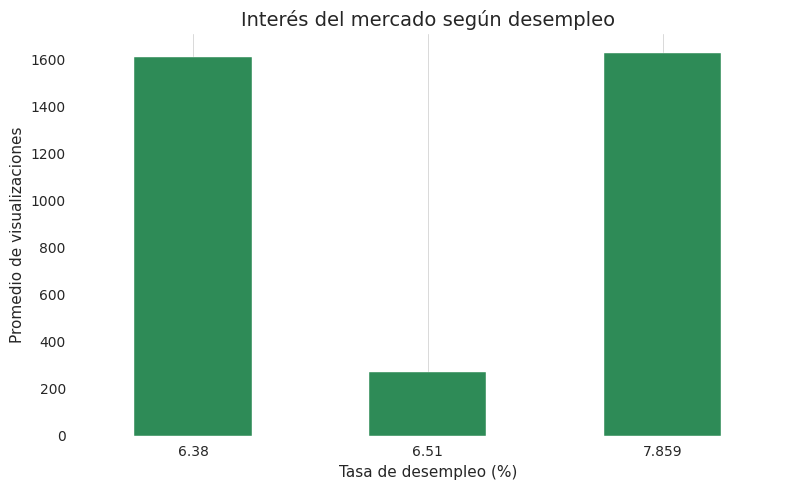

In [74]:
avg_views_unemp = df.groupby('unemployment')['times_viewed'].mean().sort_index()

plt.figure()

avg_views_unemp.plot(kind='bar')

plt.title("Interés del mercado según desempleo")
plt.xlabel("Tasa de desempleo (%)")
plt.ylabel("Promedio de visualizaciones")

plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()

plt.savefig("H3_desempleo_interes.png")
plt.show()

In [33]:
df[['times_viewed', 'unemployment']].corr()

,times_viewed,unemployment
times_viewed,1.00000,0.00266
unemployment,0.00266,1.00000


El análisis muestra que la correlación entre la tasa de desempleo y la cantidad de visualizaciones (times_viewed) es muy baja, lo que indica ausencia de relación lineal significativa.

Esto sugiere que, dentro del período analizado, el interés por los vehículos publicados no parece verse afectado de manera directa por variaciones en el nivel de desempleo.

Al igual que en las hipótesis anteriores, la variabilidad interna del comportamiento del mercado resulta considerablemente mayor que las diferencias entre años.

*H4 — Las variables macroeconómicas explican parte de la variabilidad del precio más allá de las características propias del vehículo.*

In [39]:
# Se crea un dataset específico para el modelado
# Elimino únicamente filas con valores faltantes en las variables utilizadas

df_model = df[['yr_mfr','kms_run','inflation','gdp_per_capita','unemployment','sale_price']].dropna()


Para el entrenamiento de los modelos se eliminaron únicamente las filas con valores faltantes en las variables utilizadas, con el fin de evitar sesgos por imputación artificial y garantizar consistencia en la comparación entre modelos.

In [45]:
# Modelo base
X_base = df_model[['yr_mfr','kms_run']]
y = df_model['sale_price']

X_train, X_test, y_train, y_test = train_test_split(X_base, y, test_size=0.2, random_state=42)

model_base = LinearRegression()
model_base.fit(X_train, y_train)

y_pred_base = model_base.predict(X_test)
r2_base = r2_score(y_test, y_pred_base)

In [46]:
#Modelo con macro
X_macro = df_model[['yr_mfr','kms_run','inflation','gdp_per_capita','unemployment']]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_macro, y, test_size=0.2, random_state=42)

model_macro = LinearRegression()
model_macro.fit(X_train2, y_train2)

y_pred_macro = model_macro.predict(X_test2)
r2_macro = r2_score(y_test2, y_pred_macro)

In [47]:
#Comparación
print("R2 Modelo Base:", r2_base)
print("R2 Modelo con Macro:", r2_macro)
print("Diferencia:", r2_macro - r2_base)

R2 Modelo Base: 0.27144589938092256
R2 Modelo con Macro: 0.27362204951667235
Diferencia: 0.002176150135749788


La comparación entre el modelo base (variables estructurales del vehículo) y el modelo extendido (incluyendo variables macroeconómicas) muestra que la incorporación de factores macro mejora el R² de 0.2714 a 0.2736.

La diferencia observada (≈ 0.002) es marginal, lo que indica que las variables macroeconómicas aportan una capacidad explicativa adicional muy limitada en el período analizado.

En consecuencia, el precio de los autos usados parece estar determinado principalmente por atributos propios del vehículo, mientras que el contexto macroeconómico agregado tiene un impacto reducido sobre la formación de precios individuales.

# **Conclusión General**

El presente análisis integró información macroeconómica proveniente de APIs públicas con un dataset de autos usados, con el objetivo de evaluar si el contexto económico general influye en la formación de precios y el comportamiento del mercado.

Los resultados muestran que las variables macroeconómicas (inflación, PIB per cápita y desempleo) presentan relaciones débiles o nulas con el precio y la demanda observada en el período analizado.

Asimismo, el modelado comparativo evidencia que la incorporación de variables macro mejora marginalmente el poder explicativo del modelo, confirmando que la variabilidad del precio está principalmente asociada a características estructurales del vehículo.

En este contexto, el mercado analizado se comporta como un entorno altamente heterogéneo donde los factores microeconómicos predominan sobre los indicadores macro agregados.